**Instructors**: Prof. Antonio Ortega (aortega@usc.edu)

**Teaching Assistant**: Jiazhi Li (jiazhil@usc.edu)

**Book**: Watt, J., Borhani, R., & Katsaggelos, A. K. (2020). Machine learning refined: Foundations, algorithms, and applications. Cambridge University Press.

**Notebooks**: Written by Alexios Rustom (arustom@usc.edu) and based on the following **Github repository**: [notebooks](https://github.com/jermwatt/machine_learning_refined/tree/gh-pages/presentations/2nd_edition/jupyter%20%2B%20reveal.js%20version)

# Principles of Feature Learning

In [2]:
import numpy as np
import matplotlib.pyplot as plt
readDataPath = '../readData/'
import pandas as pd
import copy
from matplotlib import gridspec
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

We saw how supervised and unsupervised learners alike can be extended to perform nonlinear learning via the use of nonlinear functions (or feature transformations) that we engineered ourselves by visually examining data.


Here we detail the fundamental tools and principles of *feature learning* (or *automatic feature engineering*) that allow us to automate this task and *learn* proper features from the data itself.

More specifically, expressing a general nonlinear model for regression and two-class classification as a weighted sum of $B$ nonlinear functions of our input as

\begin{equation}
\text{model}\left(\mathbf{x},\Theta\right) = w_0 + f_1\left(\mathbf{x}\right){w}_{1} +  f_2\left(\mathbf{x}\right){w}_{2} + \cdots + f_B\left(\mathbf{x}\right)w_B
\end{equation}

we will discuss how to:
- choose the form of the nonlinear transformations $f_1$ through $f_B$
- the number $B$ of them employed
- and, how the parameters in $\Theta$ (including $w_0$ through $w_B$) are tuned, *automatically* and for *any dataset*

where $f_1$ through $f_B$ are nonlinear parameterized or
unparameterized functions (or features) of the data, and $w_0$ through $w_B$ (along
with any additional weights internal to the nonlinear functions) are
represented in the weight set $\Theta$. 

 We saw how the quality of the mathematical features we can design ourselves is fundamentally dependent on our level of knowledge regarding the phenomenon we were studying. The more we understand (both intellectually and intuitively) the process generating the data we have at our fingertips, the better we can design features ourselves.  

At one extreme where we have near perfect understanding of the process generating our data, this knowledge having come from considerable intuitive, experimental, and mathematical reflection, the features we design allow near perfect performance. However, more often than not we know only a few facts, or perhaps none at all, about
the data we are analyzing.   

The universe is an enormous and complicated
place, and we have a solid understanding only of how a sliver of it all  works. 

Most (particularly modern) machine learning datasets have far more than two inputs, rendering visualization useless as a tool for feature engineering.

But even in rare cases where data visualization is possible, we cannot simply rely on our own pattern recognition skills.

The aim to automate nonlinear learning is an ambitious one and perhaps at first glance an intimidating one as well, for there are an infinite variety of nonlinearities and nonlinear functions to choose from. How do we, in general, parse this infinitude automatically to determine the appropriate nonlinearity for a given dataset?

The first step is to organize the pursuit of automation by first placing the fundamental building blocks of this infinitude into *manageable collections* of (relatively simple) nonlinear functions. 

These collections are often called *universal approximators*, of which three strains are popularly used and which we introduce here: fixed-shape approximators, artificial neural networks, and trees. After introducing universal approximators we then discuss the fundamental concepts underlying how they are employed, including the necessity for *validation error* as a measurement tool, a description of *cross-validation* and the *bias-variance tradeoff*, as well as the notion of *K-folds cross-validation*.

## Universal approximators

We previously described how to engineer appropriate nonlinear features ourselves to match the patterns we gleamed in simple datasets.

However very rarely in practice can we design perfect or even strongly-performing nonlinear features by completely relying on our own understanding of a dataset, whether this is gained by
visualizing the data, philosophical reflection, or domain expertise.

In this Section we jettison the unrealistic assumption that proper nonlinear features can be engineered in the manner described in the previous Chapter, and replace it with an equally unrealistic assumption that has far more practical repercussions (as we will see in the forthcoming Sections): that we have *complete* and *noiseless* access to the phenomenon generating our data.

Here we will see, in the case where we have such unfettered access to data, that absolutely perfect features can be *learned* automatically by combining elements from a set of basic feature transformations, known as *universal approximators*.

In this Section we will also see elementary exemplars from the three most popular universal approximators, namely, *fixed-shape approximators*, *neural networks*, and *trees*.

For the sake of simplicity we will restrict our discussion to nonlinear regression and two-class classification, which as we saw in Chapter 10, share the same generic nonlinear model, formed as a linear combination of $B$ nonlinear feature transformations of the input

$$
\text{model}\left(\mathbf{x},\Theta\right) = w_0 + f_1\left(\mathbf{x}\right){w}_{1} +  f_2\left(\mathbf{x}\right){w}_{2} + \cdots + f_B\left(\mathbf{x}\right)w_B. 
$$

Recall that with nonlinear two-class classification, we simply pass the nonlinear regression model above through the mathematical sign function to make binary predictions. While our focus in this Section will be on these two supervised problems, because the general nonlinear model above is used in virtually all other forms of nonlinear learning including multi-class classification  and unsupervised learning, the thrust of the story unveiled here holds more generally for all machine learning problems.

### Perfect data

A *perfect* dataset for regression or two-class classification has two important (albeit, unrealistic) characteristics:
- It is completely noiseless
- It is infinitely large

When we have unfettered access to perfect data, perfect features can be *learned* automatically by combining elements from a set of basic feature transformations, known as *universal approximators*, the most popular of which include *fixed-shape approximators*, *neural networks*, and *trees*.

- A perfect regression or two-class classification dataset is a continuous (or piece-wise continuous) function with unknown equation.

- Because of this we will refer to our perfect data using the function notation $y\left(\mathbf{x}\right)$, meaning that the data pair defined at input $\mathbf{x}$ can be written as either $\left(\mathbf{x},y\left(\mathbf{x}\right)\right)$ or likewise $\left(\mathbf{x},y\right)$.  

- It is important to bear in mind that the function notation $y\left(\mathbf{x}\right)$ does not imply that we have knowledge of a closed form *formula* relating the input/output pairs of a perfect dataset, we do not!

### The spanning set analogy for universal approximation

Here we will leverage our knowledge and intuition about basic linear algebra concepts such as vectors, spanning sets, and the like to better understand how we can combine nonlinear functions to model perfect regression and classification data. In particular we will see how vectors and nonlinear functions are very much akin when it comes to the notions of linear combination and spanning sets.

#### Linear combinations of vectors 


- Assume we have a set of $B$ vectors $\left\{\mathbf{f}_1,\,\mathbf{f}_2,\,\ldots,\,\mathbf{f}_B\right\}$, each having dimension $N$.

- We call this a *spanning* set of vectors.

- Given a particular set of weights $w_1$ through $w_B$, the linear combination below defines a new $N$ dimensional vector $\mathbf{y}$

\begin{equation}
\mathbf{f}_1w_1 + \mathbf{f}_2w_2 + \cdots + \mathbf{f}_Bw_B = \mathbf{y}
\end{equation}

#### Linear combinations of functions

Similarly, given a spanning set of $B$ nonlinear functions $\left\{f_1\left(\mathbf{x}\right),\,f_2\left(\mathbf{x}\right),\,\ldots,\,f_B\left(\mathbf{x}\right)\right\}$ (where the input $\mathbf{x}$ is $N$ dimensional and output is scalar) and a corresponding set of weights, the linear combination below defines a new function $y\left(\mathbf{x}\right)$

\begin{equation}
 w_0 + f_1\left(\mathbf{x}\right){w}_{1} +  f_2\left(\mathbf{x}\right){w}_{2} + \cdots + f_B\left(\mathbf{x}\right)w_B = y\left(\mathbf{x}\right)
 \end{equation}

#### Capacity of spanning sets

- Computing the vector $\mathbf{y}$ in $\mathbf{f}_1w_1 + \mathbf{f}_2w_2 + \cdots + \mathbf{f}_Bw_B \approx \mathbf{y}$, for a *given* set of weights $w_1$ through $w_B$, is a trivial affair.

- The inverse problem, i.e., finding the weights given $\mathbf{y}$, is slightly more challenging.

- Stated algebraically, we want to find the weights $w_1$ through $w_B$ such that the following holds as well as possible. 

\begin{equation}
\mathbf{f}_1w_1 + \mathbf{f}_2w_2 + \cdots + \mathbf{f}_Bw_B \approx \mathbf{y}
\end{equation}

How well the *vector approximation* $\mathbf{f}_1w_1 + \mathbf{f}_2w_2 + \cdots + \mathbf{f}_Bw_B \approx \mathbf{y}$ holds depends on three crucial and interrelated factors:

1. The diversity (i.e., linear independence) of the spanning vectors
2. The number $B$ of them used (in general the larger we make $B$ the better)
3. How well we tune the weights $w_1$ through $w_B$ via minimization of an appropriate cost

- Factors (1) and (2) determine a spanning set's *rank* or *capacity*, that is a measure for the range of vectors $\mathbf{y}$ we can possibly represent with such a spanning set. 

- A spanning set with a *low capacity*, that is one consisting of a non-diverse and/or a small number of spanning vectors can approximate only a tiny fraction of those present in the entire vector space.

- A spanning set with a *high capacity* can represent a broader swath of the space.

### Function approximation problem

We can try to find the weights $w_1$ through $w_B$, for a given $y\left(\mathbf{x}\right)$, such that the following holds as well as possible.

\begin{equation}
 w_0 + f_1\left(\mathbf{x}\right){w}_{1} +  f_2\left(\mathbf{x}\right){w}_{2} + \cdots + f_B\left(\mathbf{x}\right)w_B \approx y\left(\mathbf{x}\right)
 \end{equation}

As with the vector case, how well this *function approximation* holds depends on three crucial and interrelated factors:

1. The diversity of the spanning functions
2. The number $B$ of them functions used
3. How well we tune the weights $w_0$ through $w_B$ (as well as any parameters internal to our nonlinear functions) via minimization of an appropriate cost.

- In analogy to the vector case, factors (1) and (2) determine the *capacity* of a spanning set of functions.

- A *low capacity* spanning set that uses a non-diverse and/or small array of nonlinear functions is only capable of representing a small range of nonlinear functions. 

- A spanning set with a *high capacity* can represent a wider swath of functions.

Sometimes the spanning functions $f_1$ through $f_B$ are parameterized, meaning that they have internal parameters themselves. An unparameterized spanning function is very much akin to a spanning vector, as they are both parameter-free. A parameterized spanning function on the other hand can take on a variety of shapes alone, and thus can itself have high capacity. The same cannot be said about spanning vectors and unparameterized spanning functions. This concept is illustrated in where in the left column we show an ordinary spanning vector $\mathbf{x}$ (top left panel) along with an unparameterized spanning function, i.e., $\text{sin}\left(x\right)$ (bottom left panel). In the bottom right panel of the Figure we show the parameterized function $\text{sin}\left(wx\right)$ which can represent a wider range of different functions as its internal parameter $w$ is adjusted. Thinking analogously, we can also parameterize the spanning vector $\mathbf{x}$, e.g., via multiplying it by the rotation matrix

$$
R_{w}=\left[\begin{array}{cc}
\text{cos}(w) & -\text{sin}(w)\\
\text{sin}(w) & \text{cos}(w)
\end{array}\right]
$$

that allows it to rotate in the plane and represent a range of different vectors depending on how the rotation angle $w$ is set.

### Universal approximation

Consider the vector approximation problem  

$$\mathbf{f}_1w_1 + \mathbf{f}_2w_2 + \cdots + \mathbf{f}_Bw_B \approx \mathbf{y}$$

- If $B \geq N$ and at least $N$ of the vectors are linearly independent, then our spanning set has maximal capacity and we can therefore approximate *every* $N$ dimensional vector $\mathbf{y}$ to *any* given precision.

- Such a set of spanning vectors can approximate (or in this case perfectly represent) every vector *universally*.

Now consider the function approximation problem 

$$w_0 + f_1\left(\mathbf{x}\right){w}_{1} +  f_2\left(\mathbf{x}\right){w}_{2} + \cdots + f_B\left(\mathbf{x}\right)w_B \approx y\left(\mathbf{x}\right)$$

- If we choose the right kind of spanning functions, then our spanning set has maximal capacity and we can therefore approximate *every* function $y\left(\mathbf{x}\right)$ to *any* given precision. 

- Such a set of spanning functions, of which there are infinitely many varieties, can approximate every function *universally*, and is thus often referred to as a *universal approximator*. 

Note: one difference between the vector and the function regime of universal approximation is that with the latter we may need infinitely many spanning functions to be able to approximate a given function to an arbitrary precision (whereas with the former it is always sufficient to set $B$ greater than or equal to $N$). 

### Popular universal approximators

- In theory there are infinitely many universal approximators.

- However for the purposes of organization, convention, as well as a variety of technical matters universal approximators used in machine learning are often lumped into three main categories referred to as *fixed-shape approximators*, *neural networks*, and *trees*. 

- Each of these popular families has its own unique practical strengths and weaknesses as a universal approximator, a wide range of technical details to explore, and conventions of usage, which we explore in Chapters 12-14. 

#### <span style="color:#a50e3e;">Example.</span>  The fixed-shape family of universal approximators

- The family of *fixed-shape* functions consists of groups of nonlinear functions with no internal parameters, giving each a "fixed" shape. 

- Polynomials are a popular sub-family:  

\begin{equation}
f_1(x) = x, ~~ f_2(x) = x^2,~~ f_3(x)=x^3,~~ f_D(x)=x^D
\end{equation}

- A combination of the first $D$ units from this sub-family is often referred to as a *degree $D$* polynomial.

- Polynomials are *naturally ordered* by their degree.

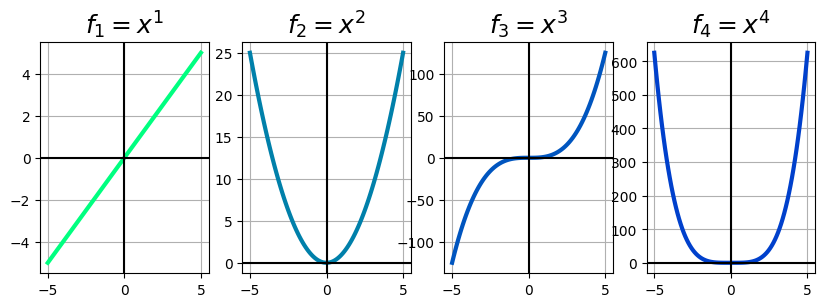

In [3]:
x = np.linspace(-5,5,100)
fig = plt.figure(figsize = (10,3))

for m in range(1,5):
    # make basis element
    fm = x**m
    fm_table = np.stack((x,fm),axis = 1)
    
    # plot the current element
    ax = fig.add_subplot(1,4,m)
    ax.plot(fm_table[:,0],fm_table[:,1],color = [0,1/float(m),m/float(m+1)],linewidth = 3)
    ax.set_title('$f_'+str(m) + ' = x^' + str(m) + '$',fontsize = 18)

    # clean up plot
    ax.grid(True, which='both')
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
plt.show()

- With two inputs $x_1$ and $x_2$, a general degree $D$ polynomial unit takes the analogous form below where $p$ and $q$ are non-negative integers and $p + q \leq D$.

$$
f_b(x_1,x_2) = x_1^px_2^q 
$$

- Classically, a degree $D$ polynomial is a linear combination of all such units. This definition directly generalizes to $N>2$ dimensional input.

<>:19: SyntaxWarning: invalid escape sequence '\,'
<>:24: SyntaxWarning: invalid escape sequence '\,'
<>:19: SyntaxWarning: invalid escape sequence '\,'
<>:24: SyntaxWarning: invalid escape sequence '\,'
/var/folders/h4/_y25lq397kbgj8ll1k7bwkww0000gn/T/ipykernel_8068/1434700782.py:19: SyntaxWarning: invalid escape sequence '\,'
  deg1 = 'x_1^{\,}'
/var/folders/h4/_y25lq397kbgj8ll1k7bwkww0000gn/T/ipykernel_8068/1434700782.py:24: SyntaxWarning: invalid escape sequence '\,'
  deg2 = 'x_2^{\,}'


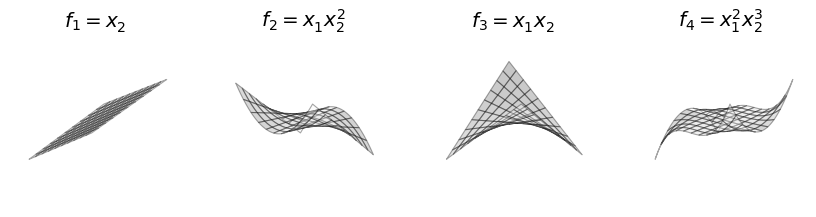

In [4]:
s = np.linspace(-2,2,100)
x_1,x_2 = np.meshgrid(s,s)
degree_dict = {}

# build 4 polynomial basis elements
fig = plt.figure(num=None, figsize = (10,4), dpi=80, facecolor='w', edgecolor='k')

### plot regression surface ###
p =  [0,1,1,2]
q = [1,2,1,3]
for m in range(4):
    ax1 = plt.subplot(1,4,m+1,projection = '3d')
    ax1.set_axis_off()
    f_m = (x_1**p[m])*(x_2**q[m])
    ax1.plot_surface(x_1,x_2,f_m,alpha = 0.35,color = 'w',zorder = 3,edgecolor = 'k',linewidth=1,cstride = 10, rstride = 10)
    ax1.view_init(20,40)  
    deg1 = ''
    if p[m] == 1:
        deg1 = 'x_1^{\,}'
    if p[m] >=2:
        deg1 = 'x_1^' + str(p[m])
    deg2 = ''
    if q[m] == 1:
        deg2 = 'x_2^{\,}'
    if q[m] >=2:
        deg2 = 'x_2^' + str(q[m])
    ax1.set_title('$f_'+str(m+1) + ' = ' + deg1 + deg2 + '$',fontsize = 18)
fig.subplots_adjust(left=0,right=1,bottom=0,top=1)   # remove whitespace around 3d figure
plt.show()

#### <span style="color:#a50e3e;">Example.</span>  The neural network family of universal approximators

- The neural networks family consists of *parameterized* functions, allowing them to take on a variety of different shapes (unlike the fixed-shape family). 

- The simplest kind of neural networks universal approximator is a parameterized elementary function  

$$
f_1(x) = \text{tanh}\left(w_{1,0} + w_{1,1}x\right), ~~ f_2(x) = \text{tanh}\left(w_{2,0} + w_{2,1}x\right), ~~ \text{etc.} 
$$


- Notice the internal parameters $w_{b,0}$ and
$w_{b,1}$ of a generic neural network function $f_b(x) = \text{tanh}\left(w_{b,0} + w_{b,1}x\right)$ allow it to take on a variety of shapes, as illustrated below (where these parameters are set randomly).

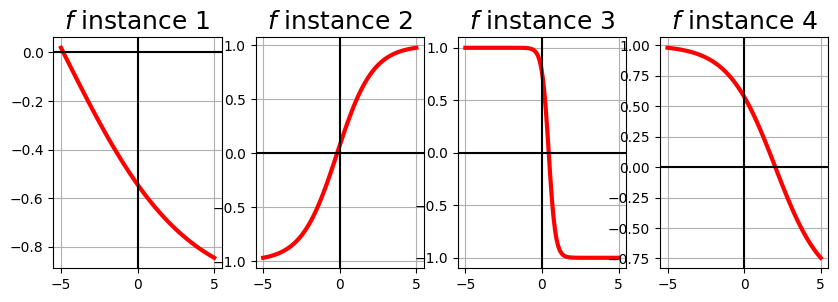

In [5]:
x = np.linspace(-5,5,100)
fig = plt.figure(figsize = (10,3))

for m in range(1,5):
    # make basis element
    w_0 = np.random.randn(1)
    w_1 = np.random.randn(1)
    fm = np.tanh(w_0 + w_1*x)
    fm_table = np.stack((x,fm),axis = 1)
    
    # plot the current element
    ax = fig.add_subplot(1,4,m)
    ax.plot(fm_table[:,0],fm_table[:,1],c='r',linewidth = 3)
    ax.set_title('$f$ instance ' + str(m),fontsize = 18)

    # clean up plot
    ax.grid(True, which='both')
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')

plt.show()

- To construct neural network features taking in higher dimensional input we take a linear combination of the input and pass the result through the nonlinear function. 
\begin{equation}
f_b\left(\mathbf{x}\right) = \text{tanh}\left(w_{b,0} + w_{b,1}x_1 + \cdots + w_{b,\,N}x_N\right)
\end{equation}

- As with the lower dimensional example, each function above can take on a variety of different shapes, as illustrated below (again with randomly-set parameters).

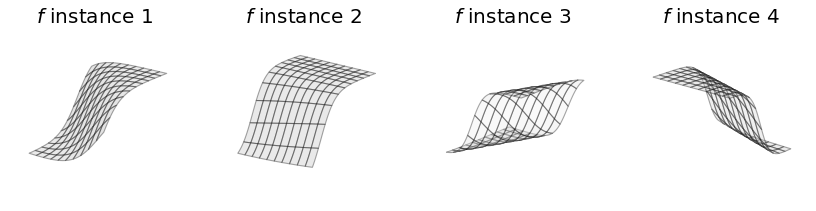

In [6]:
s = np.linspace(-2,2,100)
x_1,x_2 = np.meshgrid(s,s)
degree_dict = {}

# build 4 polynomial basis elements
fig = plt.figure(num=None, figsize = (10,4), dpi=80, facecolor='w', edgecolor='k')

### plot regression surface ###
p =  [0,1,1,2]
q = [1,2,1,3]
for m in range(4):
    ax1 = plt.subplot(1,4,m+1,projection = '3d')
    ax1.set_axis_off()
    
    # random weights
    w_0 = np.random.randn(1)
    w_1 = np.random.randn(1)
    w_2 = np.random.randn(1)
    w_3 = np.random.randn(1)
    f_m = w_3*np.tanh(w_0 + w_1*x_1 + w_2*x_2)

    ax1.plot_surface(x_1,x_2,f_m,alpha = 0.35,color = 'w',zorder = 3,edgecolor = 'k',linewidth=1,cstride = 10, rstride = 10)
    ax1.view_init(20,40) 
    ax1.set_title('$f$ instance ' + str(m+1),fontsize = 18)

fig.subplots_adjust(left=0,right=1,bottom=0,top=1)   # remove whitespace around 3d figure
plt.show()

#### <span style="color:#a50e3e;">Example.</span>  The trees family of universal approximators

- The simplest sort of tree unit consists of discrete step functions or, as they are more commonly referred to, *stumps* whose break lies along a single dimension of the input space. 

- A stump with one dimensional input $x$ can be written as follows where $s$ is called a *split point* at which the stump changes values, and $v_{1}$ and $v_{2}$ are values taken by the two sides of the stump respectively, which we refer to as *leaves* of the stump.

$$
f\left(x\right)=\begin{cases}
\begin{array}{c}
v_{1}\\
v_{2}
\end{array} & \begin{array}{c}
x<s\\
x>s
\end{array}\end{cases}
$$

- A tree-based universal approximator is a set of such stumps (see figure below). 

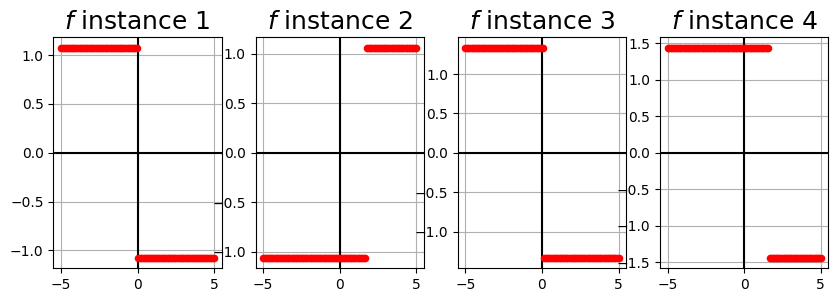

In [7]:
x = np.linspace(-5,5,100)
fig = plt.figure(figsize = (10,3))

for m in range(1,5):
    # make basis element
    w_0 = np.random.randn(1)
    w_1 = np.random.randn(1)
    w_2 = np.random.randn(1)
    fm = w_2*np.sign(w_0 + w_1*x)
    fm_table = np.stack((x,fm),axis = 1)
    
    # plot the current element
    ax = fig.add_subplot(1,4,m)
    ax.scatter(fm_table[:,0],fm_table[:,1],c='r',s = 20,zorder = 3)
    ax.set_title('$f$ instance ' + str(m),fontsize = 18)

    # clean up plot
    ax.grid(True, which='both')
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')

plt.show()

- Higher dimensional stumps follow this one dimensional pattern: a split point $v_1$ is defined along a *single* dimension, defining a linear step along a single coordinate dimension.

- Each side of the split is then assigned a single level value.

- Figure below shows four instances of a single stump defined in two dimensions.

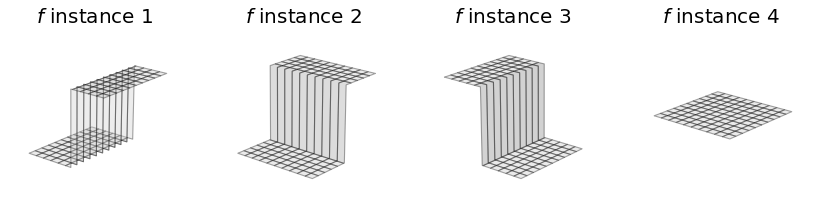

In [8]:
s = np.linspace(-2,2,100)
x_1,x_2 = np.meshgrid(s,s)
degree_dict = {}

# build 4 polynomial basis elements
fig = plt.figure(num=None, figsize = (10,4), dpi=80, facecolor='w', edgecolor='k')

### plot regression surface ###
for m in range(4):
    ax1 = plt.subplot(1,4,m+1,projection = '3d')
    ax1.set_axis_off()
    
    # random weights
    r = np.random.randint(2)
    w_0 = 0.1*np.random.randn(1)
    w_1 = np.random.randn(1)*r
    w_2 = np.random.randn(1)*(1 - r)
    w_3 = 3*np.random.randn(1)
    f_m = w_3*np.sign(w_0 + w_1*x_1 + w_2*x_2)
    
    ax1.plot_surface(x_1,x_2,f_m,alpha = 0.35,color = 'w',zorder = 3,edgecolor = 'k',linewidth=1,cstride = 10, rstride = 10)
    ax1.view_init(20,40) 
    ax1.set_title('$f$ instance ' + str(m+1),fontsize = 18)

fig.subplots_adjust(left=0,right=1,bottom=0,top=1)   # remove whitespace around 3d figure
plt.show()

### The capacity and optimization dials

$$\text{model}\left(\mathbf{x},\Theta\right) = w_0 + f_1\left(\mathbf{x}\right){w}_{1} +  f_2\left(\mathbf{x}\right){w}_{2} + \cdots + f_B\left(\mathbf{x}\right)w_B$$

With any of the major universal approximators (i.e., fixed-shape, neural networks, or trees) we can attain universal approximation to any given precision, provided that the generic nonlinear model above:

1. has sufficiently large *capacity* (e.g., by making $B$ large enough)
2. and that its parameters are tuned sufficiently well through *optimization* of an associated cost function

### Prototypical example

#### <span style="color:#a50e3e;">Example.</span>  Universal approximation of real regression data

In this example we illustrate the use of universal approximators on a real regression dataset that is based on the near-perfect sinusoidal data presented in Example 11.5. To simulate a real version of this dataset we randomly selected $P = 21$ of its points and added a small amount of random noise to the output (i.e., $y$ component) of each point.

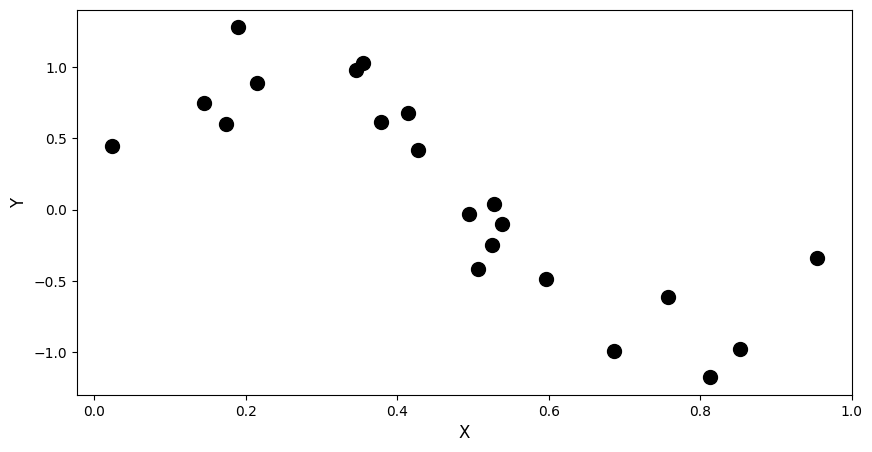

In [9]:
csvFile = readDataPath + 'noisy_sin_sample.csv'
data = np.loadtxt(csvFile,delimiter = ',')
x = data[:-1,:].T # up to last row (exclusive) of data & all columns
y = data[-1:,:].T # last row of data & all columns
plt.figure(figsize=(10, 5))
plt.scatter(x,y,s=100,facecolors='k', edgecolors='k')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.show()

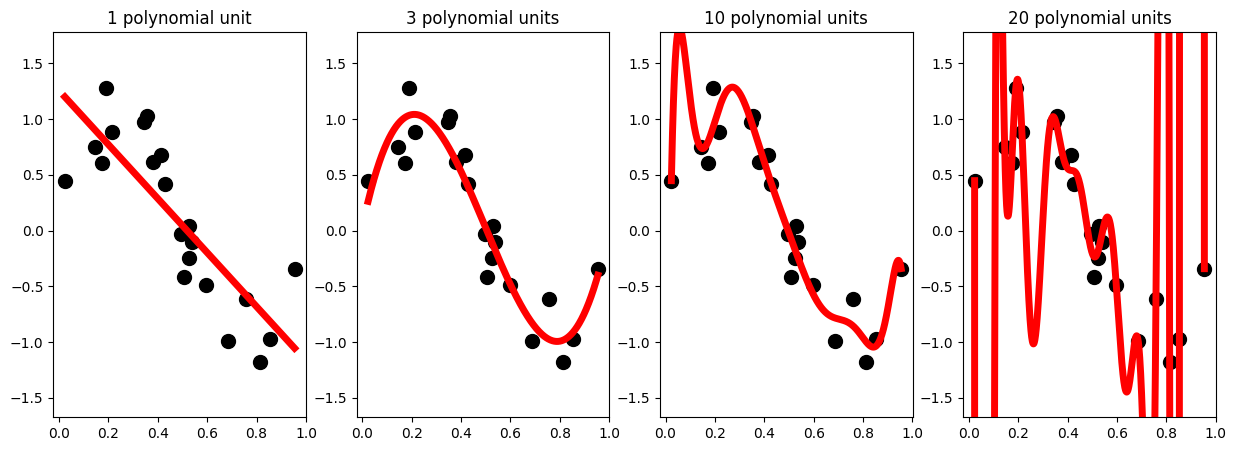

In [10]:
n=0
fig = plt.figure(figsize = (15,5))
for units in [1, 3, 10, 20]:
    ax = fig.add_subplot(1,4,n+1)
    model = LinearRegression()
    poly = PolynomialFeatures(units)
    X_transformed = poly.fit_transform(x)
    model.fit(X_transformed,y)
    ax.scatter(x,y,s=100,facecolors='k', edgecolors='k')
    x_line = np.linspace(min(x),max(x),1000)
    y_line = model.predict(poly.fit_transform(x_line))
    ax.plot(x_line,y_line,'r-',linewidth=5)
    ax.set_ylim([min(y)-0.5, max(y)+0.5])
    if (units == 1):
        ax.set_title(str(units) + ' polynomial unit')
    else:
        ax.set_title(str(units) + ' polynomial units')
    n=n+1
plt.show()

#### <span style="color:#a50e3e;">Example.</span>  Real classification data

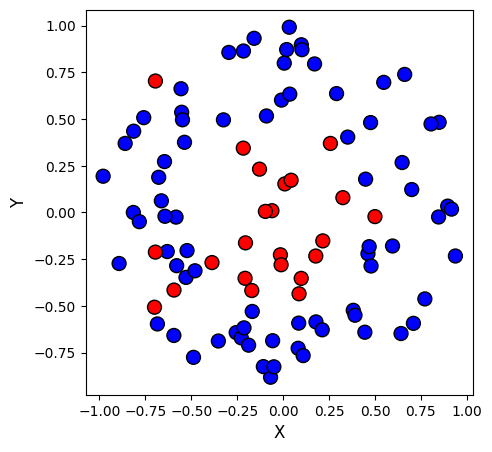

In [11]:
csvFile = readDataPath + 'new_circle_data.csv'
data = np.loadtxt(csvFile,delimiter = ',')
x = data[:-1,:].T
y = data[-1,:].T
data = pd.DataFrame(data)
data = data.T
data.columns=["X", "Y", "Label"]
plt.figure(figsize=(5, 5))
col = np.where(data["Label"]==1,'r','b')
plt.scatter(data["X"],data["Y"],s=100,c=col, edgecolors='k')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.show()

An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.

/Users/Jiazhi/miniconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/Jiazhi/miniconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/Jiazhi/miniconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/Jiazhi/miniconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be r

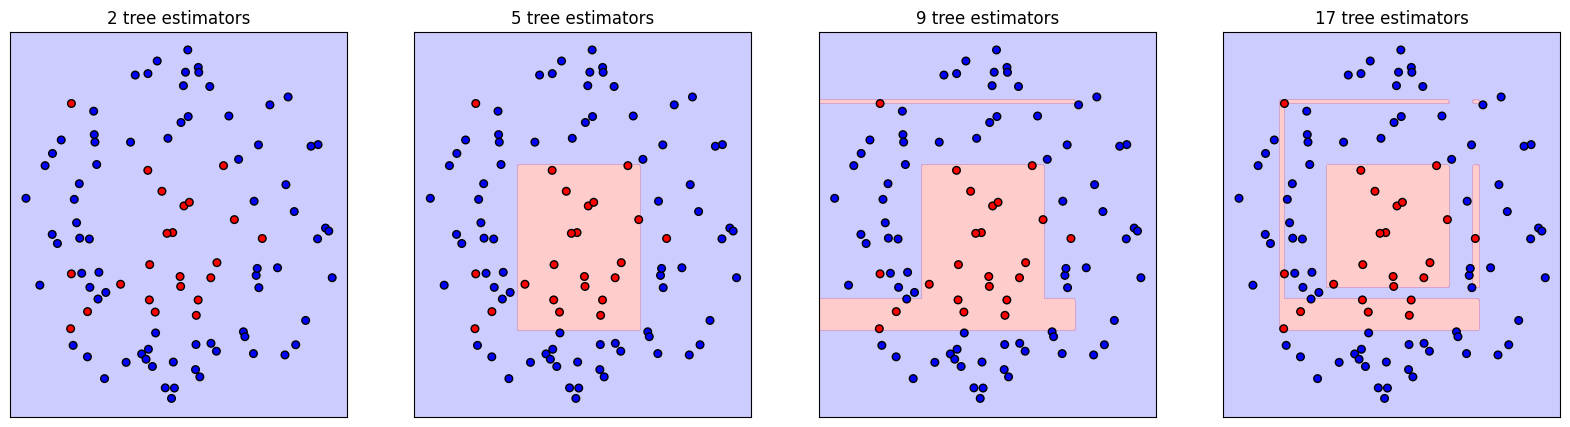

In [12]:
fig = plt.figure(figsize = (20,5))
n=0
for units_tree in [2, 5, 9, 17]:
    ax = fig.add_subplot(1,4,n+1)
    clf = AdaBoostClassifier(n_estimators=units_tree, random_state=0)
    clf.fit(x, y)
    x_min, x_max = x[:, 0].min() - 0.1, x[:, 0].max() + 0.1
    y_min, y_max = x[:, 1].min() - 0.1, x[:, 1].max() + 0.1
    h=0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    x_predicted = np.c_[xx.ravel(), yy.ravel()]
    Z = clf.predict(x_predicted)
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z+1, levels = range(0,2+1), alpha=0.2, colors = ['blue', 'red'])
    ax.scatter(data["X"],data["Y"],s=30,c=col, edgecolors='k')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(units_tree)+' tree estimators')
    n=n+1

## Naive Cross-Validation

Suppose we want to select one of the $M$ models below that has the ideal amount of complexity for a given dataset:

$$

\text{model}_1\left(\mathbf{x},\Theta_1\right) = w_0 + f_1\left(\mathbf{x}\right){w}_{1}   \,\,\,  \,\,\,  \,\,\,  \,\,\,  \,\,\,   \,\,\,  \,\,\,  \,\,\,  \,\,\,  \,\,\,    \,\,\,  \,\,\,  \,\,\,  \,\,\,  \,\,\,    \,\,\,  \,\,\,  \,\,\,  \,\,\,  \,\,\,    \,\,\,  \,\,\,  \,\,\,  \,\,\,      \,\,\,  \,\,    \\
\text{model}_2\left(\mathbf{x},\Theta_2\right) = w_0 + f_1\left(\mathbf{x}\right){w}_{1} +  f_2\left(\mathbf{x}\right){w}_{2}   \,\,\,  \,\,\,  \,\,\,  \,\,\,  \,\,\,   \,\,\,  \,\,\,  \,\,\,  \,\,\,  \,\,\,    \,\,\,  \,\,\,  \,\,\,  \,\,\,    \,\,\,   \,\,\,  \,\,   \\
\,\,\,\,\,  \,\,\,\,\, \,\,\,\,\, \,\,\,\,\,  \,\,\,\,\,  \,\,\,\,\,  \,\,\,\,\,\vdots  \,\,\,  \,\,\,  \,\,\,  \,\,\,    \,\,\,  \,\,\,  \,\,\,  \,\,\,    \\
\text{model}_M\left(\mathbf{x},\Theta_M\right) = w_0 + f_1\left(\mathbf{x}\right){w}_{1} +  f_2\left(\mathbf{x}\right){w}_{2} + \cdots + f_M\left(\mathbf{x}\right)w_M
$$

Naive cross-validation entails taking the following steps:

- split original data randomly into training and validation portions
- optimize every model to completion
- measure the error of all $M$ fully trained models on each portion of the data
- pick the one that achieves *minimum validation*

#### <span style="color:#a50e3e;">Example.</span>  Naive cross-validation and regression

- In the animation that follows we use naive cross-validation on a toy regression dataset by employing a small set of polynomial models having degrees $1 \leq m \leq 8$.

- These models are naturally ordered from low to high capacity, as we increase the degree $m$ of the polynomial.

- Here we use $\frac{2}{3}$ of the data points for training (blue), and the other $\frac{1}{3}$ for validation (yellow).

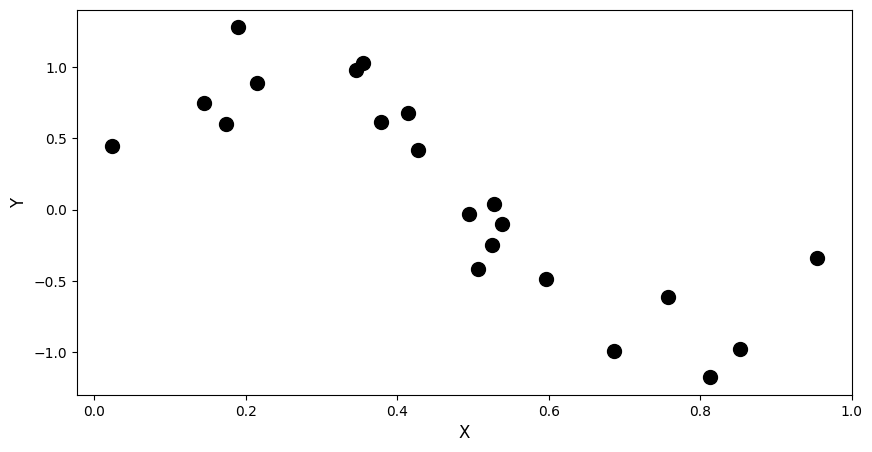

In [13]:
csvFile = readDataPath + 'noisy_sin_sample.csv'
data = np.loadtxt(csvFile,delimiter = ',')
x = data[:-1,:].T # up to last row (exclusive) of data & all columns
y = data[-1:,:].T # last row of data & all columns
plt.figure(figsize=(10, 5))
plt.scatter(x,y,s=100,facecolors='k', edgecolors='k')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.show()

In [14]:
X_train, X_val, y_train,y_val =  train_test_split(x, y, test_size=0.333, random_state = 17)

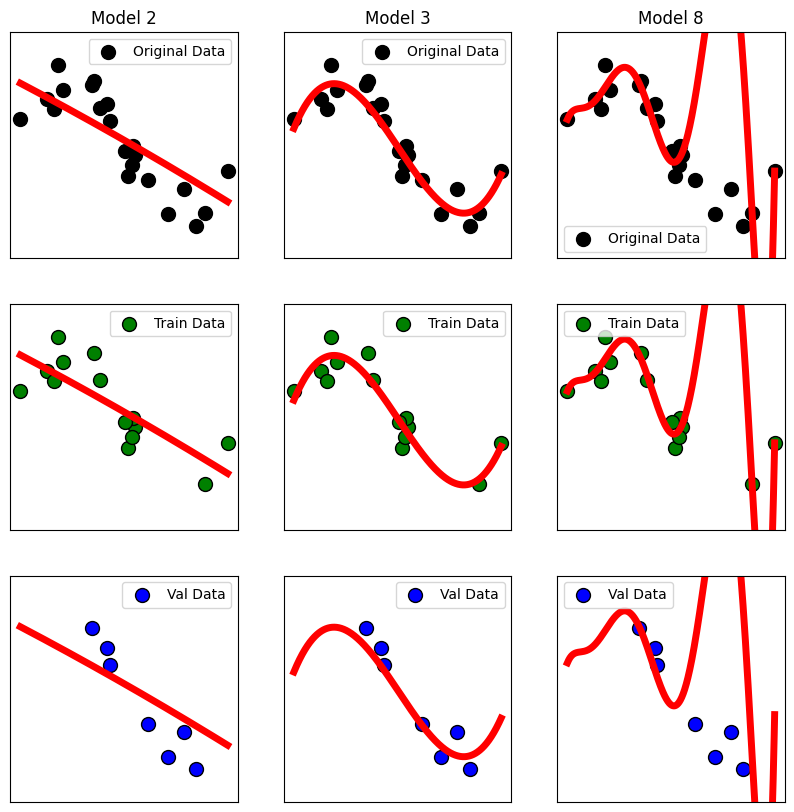

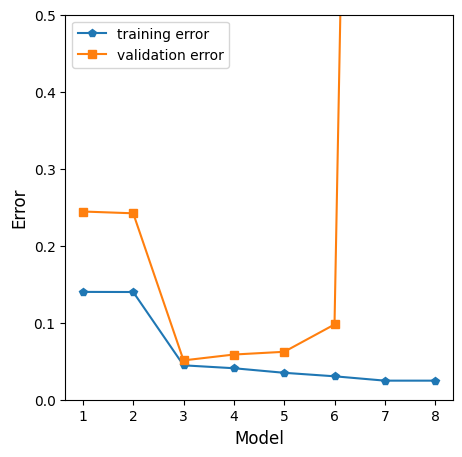

In [15]:
fig, axs = plt.subplots(3,3, figsize = (10,10))
n=0
model1 = 2; model2 = 3; model3 = 8
train_score = []; val_score = []
for i in [1,2,3,4,5,6,7,8]: 
    model = LinearRegression()
    poly = PolynomialFeatures(i)
    X_transformed = poly.fit_transform(X_train)
    model.fit(X_transformed,y_train)
    train_score.append(mean_squared_error(model.predict(poly.fit_transform(X_train)), y_train))
    val_score.append(mean_squared_error(model.predict(poly.fit_transform(X_val)), y_val))
    if (i == model1 or i==model2 or i==model3):
        x_line = np.linspace(min(x),max(x),1000)
        y_line = model.predict(poly.fit_transform(x_line))
        axs[0,n].plot(x_line,y_line,'r-',linewidth=5)
        axs[1,n].plot(x_line,y_line,'r-',linewidth=5)
        axs[2,n].plot(x_line,y_line,'r-',linewidth=5)
        axs[0,n].set_ylim([min(y)-0.5, max(y)+0.5])
        axs[0,n].scatter(x,y, s=100,facecolors='k', edgecolors='k', label = 'Original Data')
        axs[1,n].scatter(X_train,y_train,s=100,facecolors='g', edgecolors='k', label = 'Train Data')
        axs[2,n].scatter(X_val,y_val,s=100,facecolors='b', edgecolors='k', label = 'Val Data')
        #axs[i,0].plot(x_predicted,y_predicted,'r-',linewidth=5)
        axs[0,n].legend()
        axs[1,n].legend()
        axs[2,n].legend()
        axs[0,n].set_ylim([min(y)-0.5, max(y)+0.5])
        axs[1,n].set_ylim([min(y)-0.5, max(y)+0.5])
        axs[2,n].set_ylim([min(y)-0.5, max(y)+0.5])
        axs[0,n].set_title('Model ' + str(i))
        axs[0,n].set_xticks([])
        axs[0,n].set_yticks([])
        axs[1,n].set_xticks([])
        axs[1,n].set_yticks([])
        axs[2,n].set_xticks([])
        axs[2,n].set_yticks([])
        n = n+1
plt.figure(figsize = (5,5))
plt.plot(range(1,9),train_score,'p-',label = 'training error')
plt.plot(range(1,9),val_score, 's-',label = 'validation error')
plt.ylabel('Error', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.ylim([0, 0.5])
plt.legend()
plt.show()

#### <span style="color:#a50e3e;">Example.</span>   Naive cross-validation and classification

- In the animation that follows we use naive cross-validation on a toy classification dataset by employing a small set of polynomial models having degrees $1 \leq m \leq 7$.

- These models are naturally ordered from low to high capacity, as we increase the degree $m$ of the polynomial.

- Here we use (approximately) $\frac{4}{5}$ of the data points for training (blue), and the other $\frac{1}{5}$ for validation (yellow).

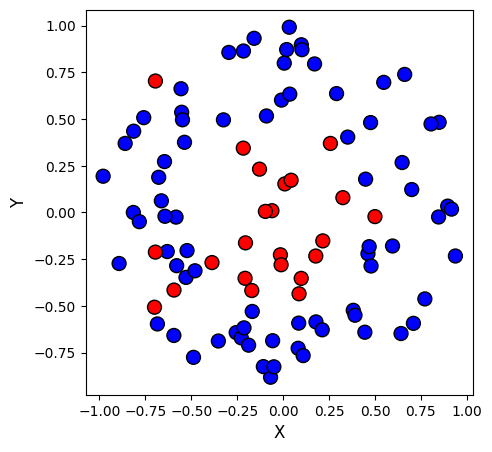

In [16]:
csvFile = readDataPath + 'new_circle_data.csv'
data = np.loadtxt(csvFile,delimiter = ',')
x = data[:-1,:].T
y = data[-1,:].T
data = pd.DataFrame(data)
data = data.T
data.columns=["X", "Y", "Label"]
plt.figure(figsize=(5, 5))
col = np.where(data["Label"]==1,'r','b')
plt.scatter(data["X"],data["Y"],s=100,c=col, edgecolors='k')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.show()

In [17]:
X_train, X_val, y_train,y_val =  train_test_split(x, y, test_size=0.2, random_state = 17)
col_train = np.where(y_train==1,'r','b')
col_val = np.where(y_val==1,'r','b')

/Users/Jiazhi/miniconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/Jiazhi/miniconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/Jiazhi/miniconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/Jiazhi/miniconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be r

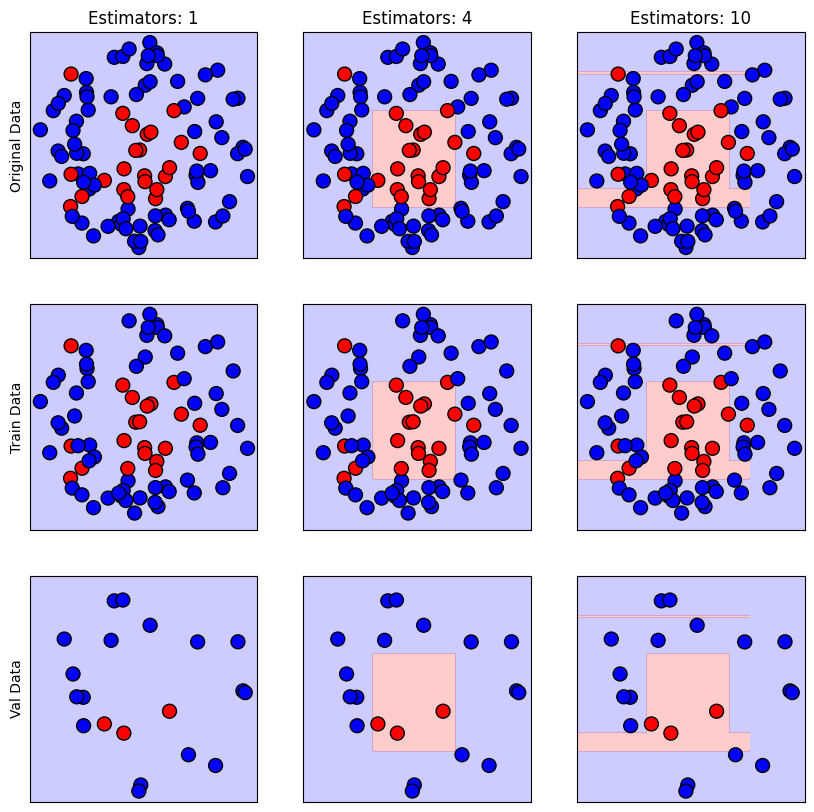

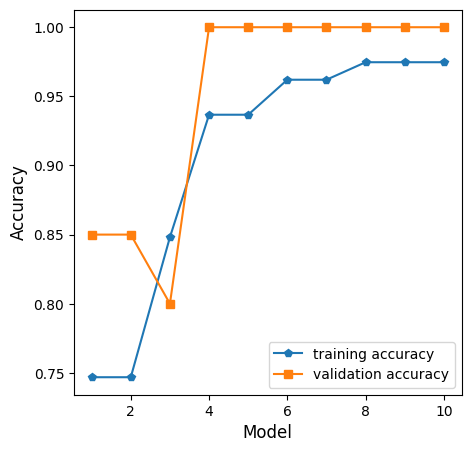

In [18]:
fig, axs = plt.subplots(3,3, figsize = (10,10))
n=0
model1 = 1; model2 = 4; model3 = 10
train_score = []; val_score = []

x_min, x_max = x[:, 0].min() - 0.1, x[:, 0].max() + 0.1
y_min, y_max = x[:, 1].min() - 0.1, x[:, 1].max() + 0.1
h=0.01
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
x_predicted = np.c_[xx.ravel(), yy.ravel()]

for units_tree in [1,2,3,4,5,6,7,8,9,10]: 
    clf = AdaBoostClassifier(n_estimators=units_tree, random_state=0)
    clf.fit(x, y)
    train_score.append(accuracy_score(clf.predict(X_train), y_train))
    val_score.append(accuracy_score(clf.predict(X_val), y_val))
    if (units_tree == model1 or units_tree==model2 or units_tree==model3):
        Z = clf.predict(x_predicted)
        Z = Z.reshape(xx.shape)
        axs[0,n].contourf(xx, yy, Z+1, levels = range(0,2+1), alpha=0.2, colors = ['blue', 'red'])
        axs[1,n].contourf(xx, yy, Z+1, levels = range(0,2+1), alpha=0.2, colors = ['blue', 'red'])
        axs[2,n].contourf(xx, yy, Z+1, levels = range(0,2+1), alpha=0.2, colors = ['blue', 'red'])
        axs[0,n].scatter(data["X"],data["Y"],s=100,c=col, edgecolors='k')
        if (units_tree==1):
            axs[0,n].set_ylabel('Original Data')
            axs[1,n].set_ylabel('Train Data')
            axs[2,n].set_ylabel('Val Data')
        axs[1,n].scatter(X_train[:,0],X_train[:,1],c = col_train, s=100, facecolors='g', edgecolors='k', label = 'Train Data')
        axs[2,n].scatter(X_val[:,0],X_val[:,1],s=100, c = col_val, facecolors='b', edgecolors='k', label = 'Val Data')
        axs[0,n].set_title('Estimators: ' + str(units_tree))
        axs[0,n].set_xticks([])
        axs[0,n].set_yticks([])
        axs[1,n].set_xticks([])
        axs[1,n].set_yticks([])
        axs[2,n].set_xticks([])
        axs[2,n].set_yticks([])
        n = n+1
plt.figure(figsize = (5,5))
plt.plot(range(1,model3+1),train_score,'p-',label = 'training accuracy')
plt.plot(range(1,model3+1),val_score, 's-',label = 'validation accuracy')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.legend()
plt.show()

## Problems with naive cross-validation

- Since the process generally involves trying out a range of models where each model is *optimized completely*, naive cross-validation can be very expensive computationally speaking. 

- The *capacity* difference between even adjacent models (e.g., those consisting of $m$ and $m+1$ units) can be quite large. Since each model is fully optimized this can lead to huge jumps in the range of model complexities tried out on a dataset, leading to a *coarse* resolution model search that can 'miss out' on an ideal amount of nonlinearity for a given dataset.  

## Testing data

- As with training data, it is also possible to overfit to validation data as well during the cross-validation procedure. 

- Provided the dataset is large enough, we can ameliorate this risk by splitting our original data into not two sets (training and validation), but three: <u><b>training</b></u>, <u><b>validation</b></u>, and <u><b>testing</b></u> sets.

## Which Universal Approximator Works Best in Practice?

- It is virtually never clear a priori which, if any, of the universal approximators will work best.

- Indeed cross-validation is the toolset one uses in practice to decide which type of universal approximator based model works best for a particular problem. 

- However, broad understanding of a dataset can, in some instances, direct the choice of universal approximator. 

### Naturally discontinuous data

Because oftentimes business, census, and (more generally) structured datasets consist of broad mixtures of continuous and discontinuous categorical input features, <u><b>tree-based universal approximators</b></u>, with their discontinuous step-like shapes, often provide stronger results on average than other universal approximator types.

### Naturally continuous data

Data that is naturally continuous (e.g., data generated by natural processes or sensor data) is often better matched with a continuous universal approximator: <u><b>fixed-shape</b></u> or <u><b>neural network</b></u>.

### Interpolation vs. extrapolation

When future predictions need be made outside the input domain of the original dataset, <u><b>fixed-shape</b></u> or <u><b>neural network</b></u> approximators can be preferred over trees – the latter by their very nature always creating perfectly flat predictions outside of the original data’s input domain.

### Human interpretability

Due to their discrete branching structure, <u><b>tree-based universal approximators</b></u> can often be much easier to interpret than other approximators (particularly neural networks).

## K-Fold Cross-Validation

- With ensembling <u>**human interpretability**</u> is typically lost as the final model is an average of many potentially very different nonlinearities. 

- K-fold cross-validation is often applied when interpretability of a final model is important.

- Instead of averaging a set of cross-validated models over many splits of the data (ensembling), with K-fold cross-validation we choose a single model that has minimum *average validation error* over all splits of the data.

- This produces a potentially less accurate final model, but one that is significantly simpler and hence more easily understood by humans. 

### The K-fold cross-validation procedure

To further simplify the final outcome of this procedure instead of using completely random training-validation splits, as done with ensembling, we split the data randomly into a set of $K$ non-overlapping pieces. The original data is represented as the entire circular mass is split into $K=3$ non-overlapping sets.  We then cycle through $K$ training-validation splits of the data that consist of $K-1$ of these pieces as training, with the final portion as validation, which allows for each point in the dataset to belong to a validation set precisely one time.  Each such split is referred to as a *fold*, of which there are $K$ in total, hence the name 'K-folds.'  On each fold we cross-validate the *same set of models* and record the validation score of each.  Afterwards we choose the single best model that produced the lowest *average validation error*.  Once this is done the minimum average validation model is re-trained over the entire dataset to provide a final tuned predictor of the data.  

Since no models are combined / averaged together with K-folds, it can very easily produce less accurate models (in terms of *testing error*) for general learning problems when compared to ensembling.  However, when human interpret-ability of a model overshadows the needs for exceptional performance, K-folds produces a stronger performing model than a single cross-validated model that can still be understood by human beings.  This is somewhat analogous to the story of feature selection, where human interpret-ability is the guiding motivator (and not simply model effectiveness).  In fact the notion of feature selection and K-folds cross-validation indeed intersect in certain applications, one of which we will see in the Examples below.

#### <span style="color:#a50e3e;">Example.</span>   Galileo's gravity experiment

In [19]:
csvname = readDataPath + 'galileo_ramp_data.csv'
data = np.loadtxt(csvname,delimiter = ',')

# get input/output pairs
x = data[:-1,:].T
y = data[-1:,:].T 

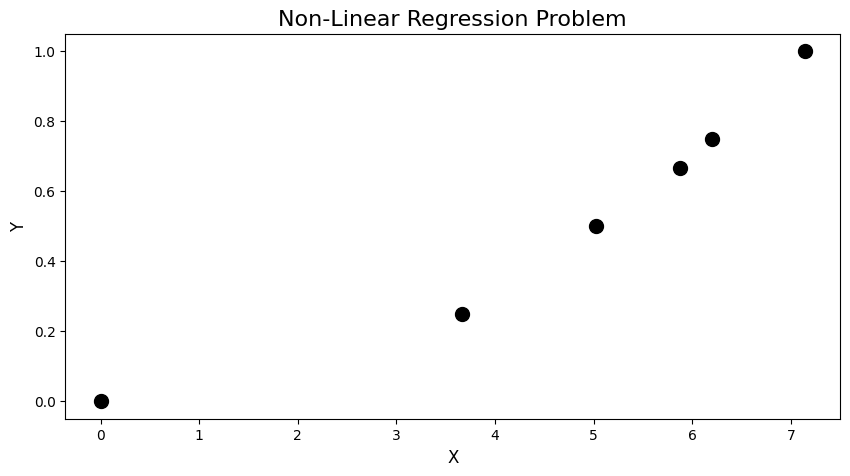

In [20]:
plt.figure(figsize=(10, 5))
plt.scatter(x,y,s=100,facecolors='k', edgecolors='k')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.title('Non-Linear Regression Problem', fontsize=16)
plt.show()

In [21]:
kfold = KFold(n_splits = 6, random_state = 7, shuffle=True)
for train, test in kfold.split(x):
    print('train: %s, test: %s' % (train, test))

train: [0 1 2 4 5], test: [3]
train: [0 1 2 3 4], test: [5]
train: [1 2 3 4 5], test: [0]
train: [0 1 3 4 5], test: [2]
train: [0 2 3 4 5], test: [1]
train: [0 1 2 3 5], test: [4]


Average Validation errors of models:  [0.06528172913538456, 0.0006162984331278498, 0.10877226176273767, 12.750399690831516, 0.6541151870272824, 0.07321590210086865, 0.015874240674246604]


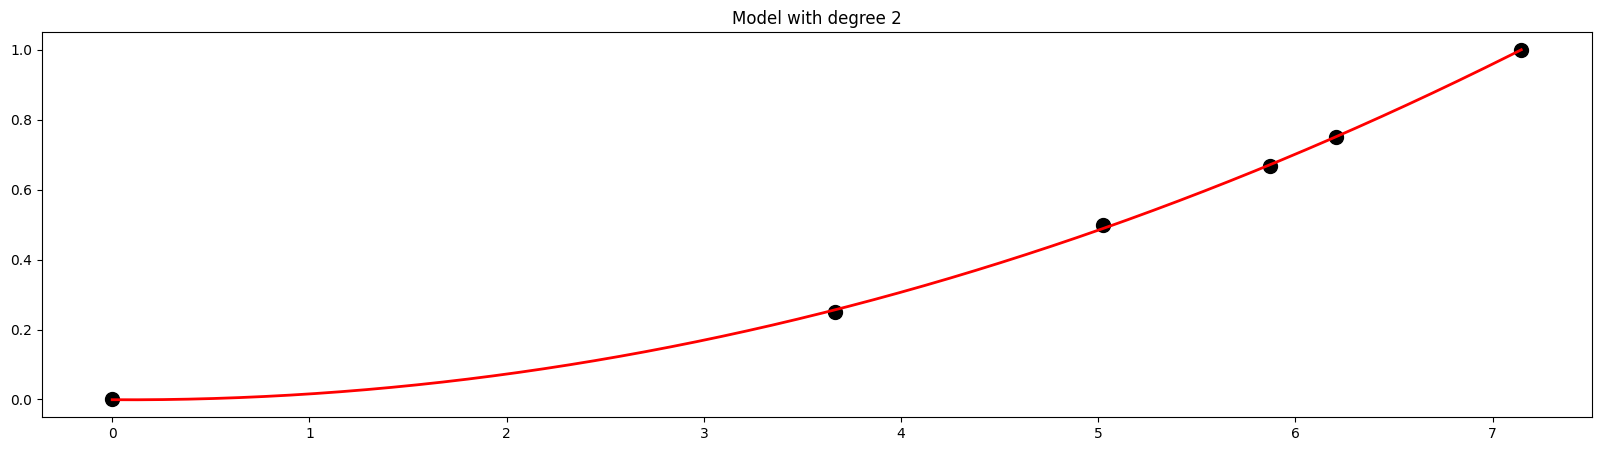

In [22]:
index_min  = []
error_min = []
plt.figure(figsize = (20,5))

for degree in [1,2,3,4,5,6,7]:
    n=0
    model = LinearRegression()
    error = []
    poly = PolynomialFeatures(degree)
    for train, test in kfold.split(x):
        min = 10000
        X_transformed = poly.fit_transform(x[train])
        model.fit(X_transformed,y[train])
        error.append(mean_squared_error(model.predict(poly.fit_transform(x[test])), y[test]))
    if (degree==2): #I know that it is associated with lowest average error
        x_line = np.linspace(np.min(x),np.max(x),1000).reshape(-1,1)
        y_line = model.predict(poly.fit_transform(x_line))
        plt.plot(x_line,y_line,'r-',linewidth=2)
        plt.scatter(x,y, s=100,facecolors='k', edgecolors='k', label = 'Original Data')
        plt.title('Model with degree ' +str(degree))
        n=n+1
    error_min.append(np.mean(error))
print('Average Validation errors of models: ', error_min)
plt.show()